## 🎯 PROJECT: Predicting Buyer Intent from Online Shopper Behavio
the goal of this project is to build a classification model that **predicts whether an online shopper will complete a purchase based on their session behavior.**

this helps businesses target potential buyers more effectively and avoid wasting ad spend on users who are unlikely to convert.


In [10]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


### 🧠 step 2: load + prep data    
- convert Revenue and Weekend from true/false to 0/1  
- use label encoding to turn text data (Month, VisitorType) into numbers  

🔍 why: models can’t work with text or boolean — it needs all numeric input.

In [11]:
# load csv
df = pd.read_csv("/Users/Nylab/Downloads/online_shoppers_intention.csv") 

# make a copy so og stays safe
data = df.copy()

# turn true/false to 0/1
data['Weekend'] = data['Weekend'].astype(int)
data['Revenue'] = data['Revenue'].astype(int)

# label encode strings
le_month = LabelEncoder()
le_visitor = LabelEncoder()
data['Month'] = le_month.fit_transform(data['Month'])
data['VisitorType'] = le_visitor.fit_transform(data['VisitorType'])


In [12]:
# preview the data
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


### 🧠 step 2.5: normalize features  
normalize the data so all features are on the same scale.  
this helps logistic regression (and other models) converge better, especially when some columns (like durations) are way bigger than others (like bounce rate).  

🔍 why: models like logistic regression assume features are scaled similarly  
🔑 look for: warning messages disappearing + better performance

In [13]:
from sklearn.preprocessing import StandardScaler

# split feat + target
X = data.drop(columns=['Revenue'])
y = data['Revenue']

# scale feat
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### 🧠 step 3: split into train/test  
split our dataset into two parts:  
- training (80%) → to teach the model  
- testing (20%) → to check how well it learned  

🔍 why: we need a clean way to test performance on "new" data  
🔑 look for: balance (so we get a fair mix of buyers and non-buyers)

In [14]:
# split train + test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42, test_size=0.2)

### 🧠 step 4: Logistic regression  
train a baseline model using logistic regression
since data was scaled earlier, this should now run without any convergence warnings.  

🔍 why: gives a starting point to compare future models  
🧠 interpretability: it’s easier to explain than other black-box models

In [15]:
# logistic model (baseline)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
log_preds = logreg.predict(X_test)


### 🧠 step 5: Xgboost  
now train a more advanced model —> XGBoost.  
this is a boosting algorithm that usually improves performance over simpler models.

🔍 why: want to see if a more complex model improves accuracy, recall, or AUC  
🔑 look for: better scores than logistic regression

In [16]:
# xgboost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)


### 🧠 step 5.5: Weighted xgboost  
now im testing xgboost again but im adding weight so it focuses more on the ppl who actually buy  
since the dataset has wayyy more non-buyers, this should help the model catch more real buyers   

🔍 why: our data has way more non-buyers than buyers  
🧠 goal: increase **recall** by helping the model find more actual buyers  
✅ look for: higher recall, possibly higher f1 or auc too

In [18]:
# define score function to print metrics
def get_scores(y_true, preds, name):
    print(f"\n{name} results:")
    print("acc:", accuracy_score(y_true, preds))
    print("prec:", precision_score(y_true, preds))
    print("recall:", recall_score(y_true, preds))
    print("f1:", f1_score(y_true, preds))
    print("roc auc:", roc_auc_score(y_true, preds))
    print("conf matrix:\n", confusion_matrix(y_true, preds))

In [19]:
# calc class weight (majority / minority)
scale = (y == 0).sum() / (y == 1).sum()

# re-train xgb with weighting
xgb_weighted = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=scale)
xgb_weighted.fit(X_train, y_train)
xgb_weighted_preds = xgb_weighted.predict(X_test)

# eval
get_scores(y_test, xgb_weighted_preds, "xgboost (weighted)")



xgboost (weighted) results:
acc: 0.878345498783455
prec: 0.5944700460829493
recall: 0.675392670157068
f1: 0.6323529411764706
roc auc: 0.7954698475545416
conf matrix:
 [[1908  176]
 [ 124  258]]


### 🧠 step 6: evaluate all 3 models  
we're comparing:  
1. **logistic regression** – simple, interpretable  
2. **xgboost** – strong baseline, better recall  
3. **weighted xgboost** – same as xgboost but gives more attention to buyers  

we’re evaluating using:
- **accuracy**: total correctness  
- **precision**: how many predicted buyers were actually buyers  
- **recall**: how many real buyers the model found  
- **f1 score**: balance of prec + recall  
- **auc**: overall classification strength  
- **confusion matrix**: see where each model succeeds/fails

🔍 what to look for:
- higher **recall** = better at finding buyers  
- higher **f1** = better balance  
- **auc > 0.75** = strong model  


In [24]:
# eval all 3 models
get_scores(y_test, log_preds, "logistic")
get_scores(y_test, xgb_preds, "xgboost")
get_scores(y_test, xgb_weighted_preds, "xgboost (weighted)")



logistic results:
acc: 0.8832116788321168
prec: 0.7640449438202247
recall: 0.35602094240837695
f1: 0.4857142857142857
roc auc: 0.6679336957723266
conf matrix:
 [[2042   42]
 [ 246  136]]

xgboost results:
acc: 0.889294403892944
prec: 0.6697819314641744
recall: 0.56282722513089
f1: 0.6116642958748222
roc auc: 0.7559817507612223
conf matrix:
 [[1978  106]
 [ 167  215]]

xgboost (weighted) results:
acc: 0.878345498783455
prec: 0.5944700460829493
recall: 0.675392670157068
f1: 0.6323529411764706
roc auc: 0.7954698475545416
conf matrix:
 [[1908  176]
 [ 124  258]]


### ✅ Final model chosen
i went with **weighted xgboost** because it had the best recall (0.67), highest f1 (0.63), and strongest auc (0.80)  
that means it finds more real buyers without doing too many wrong predictions  
for this project, that's what matters most


## 📊 CHOSEN VISUALIZATIONS
i added a few visuals to help show the results better:
- a bar chart comparing model scores  
- confusion matrices to show prediction breakdowns  
- roc curves to show how well each model separates classes  

they all back up why weighted xgboost was the best choice


### 📊 visual 1: model performance comparison (bar chart)

this bar chart compares key evaluation metrics across all three models:  
- **logistic regression**  
- **xgboost**  
- **weighted xgboost**

it shows:  
- how each model performed on **accuracy, precision, recall, f1 score, and AUC**  
- how **weighted xgboost** had the best **recall, f1, and AUC**, making it the most balanced and effective model overall

✅ this chart gives a **quick, visual summary** of why weighted xgboost was chosen as the final model
 

/var/folders/ct/ccv32kl56x15kjkzsdh670800000gn/T/ipykernel_61841/1468340646.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


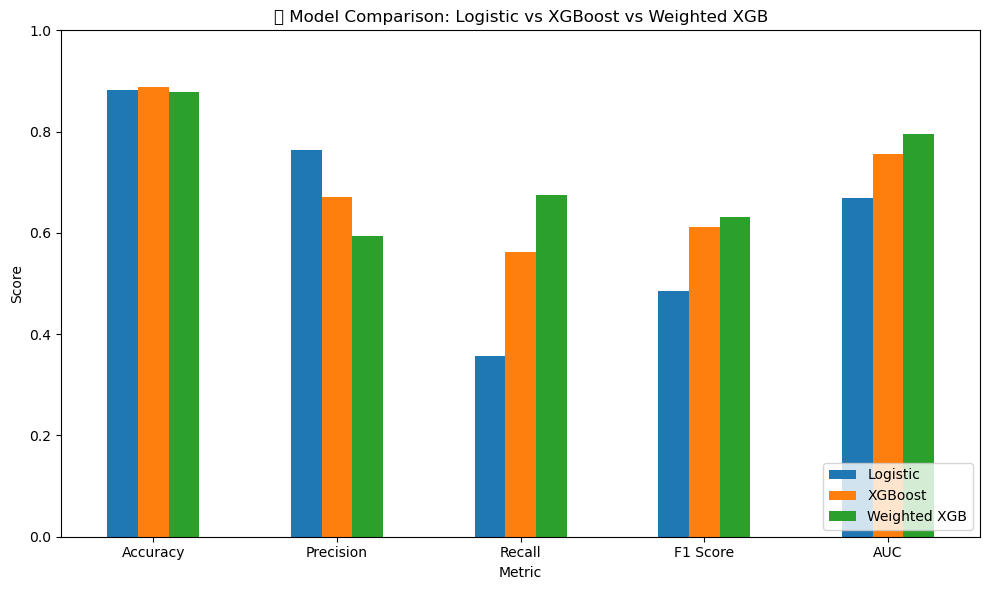

In [21]:
# create comparison df
scores = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Logistic': [0.883, 0.764, 0.356, 0.486, 0.668],
    'XGBoost': [0.889, 0.670, 0.563, 0.612, 0.756],
    'Weighted XGB': [0.878, 0.594, 0.675, 0.632, 0.795]
})

# plot
scores.set_index('Metric').plot(kind='bar', figsize=(10,6))
plt.title("📊 Model Comparison: Logistic vs XGBoost vs Weighted XGB")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### 🔍 visual 2: confusion matrices for all models
each box shows how the model predicted:  
- tp = predicted yes, actually yes  
- tn = predicted no, actually no  
- fp = predicted yes, but they didnt buy  
- fn = predicted no, but they DID buy (this hurts recall)




what they show:  
- logistic regression **missed the most buyers** (high FN, low TP)  
- regular xgboost improved recall, but still missed 167 buyers  
- the weighted xgboost had the most **true positives (258)** and less fn than the other models — so it **caught more real buyers and missed less ppl overall**

✅ this supports our goal of **maximizing recall**, making sure we don’t lose customers who are ready to convert


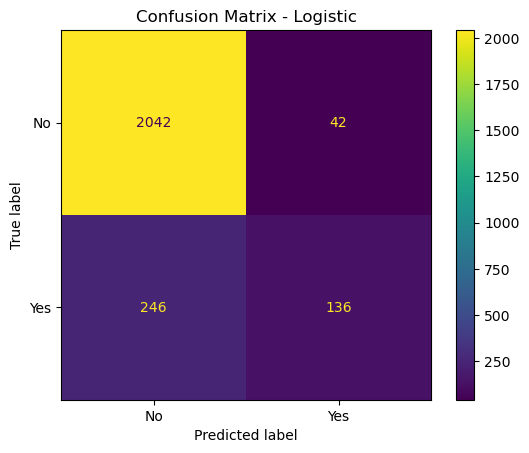

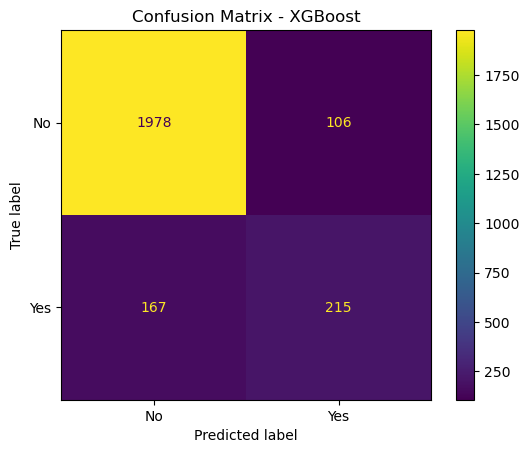

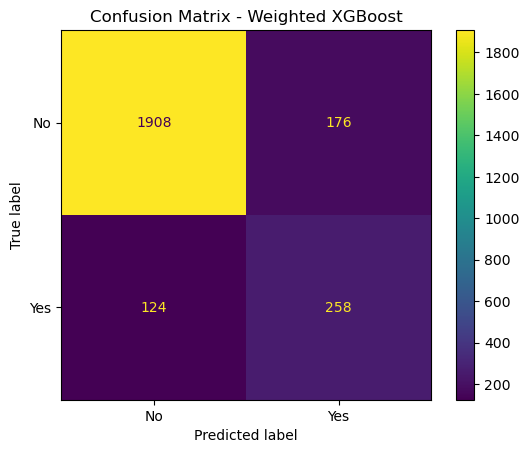

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

# logistic
ConfusionMatrixDisplay.from_predictions(y_test, log_preds, display_labels=["No", "Yes"])
plt.title("Confusion Matrix - Logistic")
plt.show()

# xgboost
ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds, display_labels=["No", "Yes"])
plt.title("Confusion Matrix - XGBoost")
plt.show()

# weighted xgboost
ConfusionMatrixDisplay.from_predictions(y_test, xgb_weighted_preds, display_labels=["No", "Yes"])
plt.title("Confusion Matrix - Weighted XGBoost")
plt.show()


### 📈 visual 3: roc curves (logistic, xgboost, weighted xgboost)

these roc (receiver operating characteristic) curves compare how well each model separates buyers from non-buyers across all thresholds.

- the **x-axis** shows the false positive rate (how often the model says "yes" when the answer is "no")
- the **y-axis** shows the true positive rate (how often the model correctly says "yes")

the **dashed gray line** represents **random guessing** — a model that can’t distinguish buyers from non-buyers. any model above that line is doing better than chance.

📊 **what the curves show:**
- **logistic regression** has the lowest curve and an auc of **0.67**, meaning it struggles to separate classes
- **xgboost** improves significantly, with an auc of **0.76**
- **weighted xgboost** performs the best, with an auc of **0.80**, and its curve is the highest overall

✅ this visual supports that **weighted xgboost** has the strongest ability to distinguish buyers from non-buyers, which is critical for reducing missed conversions and wasted ad spend.


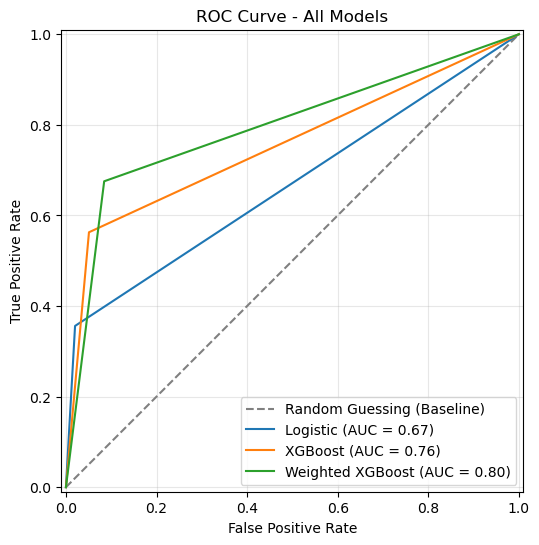

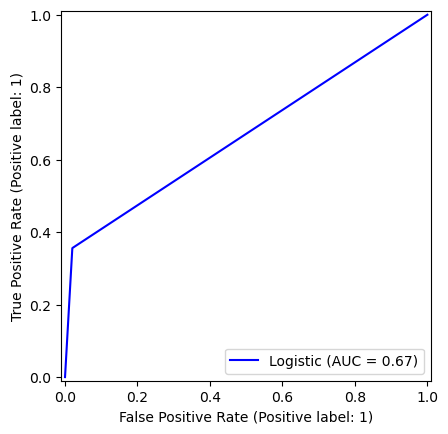

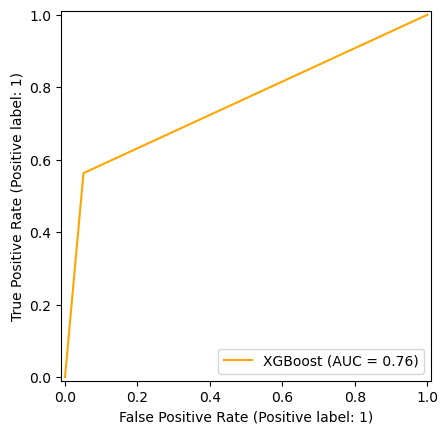

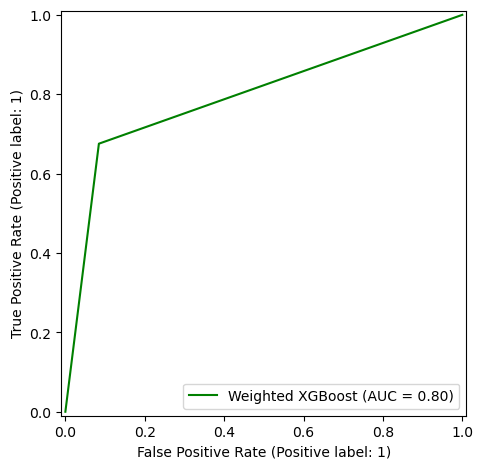

In [ ]:
from sklearn.metrics import RocCurveDisplay

# create main figure and axis
fig, ax = plt.subplots(figsize=(8,6))

# baseline line (random guess)
ax.plot([0,1], [0,1], linestyle='--', color='gray', label='Random Guessing (Baseline)')

# plot all roc curves on the same axis
RocCurveDisplay.from_predictions(y_test, log_preds, name="Logistic", color='blue').plot(ax=ax)
RocCurveDisplay.from_predictions(y_test, xgb_preds, name="XGBoost", color='orange').plot(ax=ax)
RocCurveDisplay.from_predictions(y_test, xgb_weighted_preds, name="Weighted XGBoost", color='green').plot(ax=ax)

# formatting
ax.set_title("ROC Curve - All Models")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.grid(alpha=0.3)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()
